In [6]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema

In [30]:
def search_stock_symbol(company_name):
    # Alpha Vantage API URL for SYMBOL_SEARCH
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={company_name}&apikey=Y9DN79N2PBBK2X1O'
    
    # Send request to Alpha Vantage API
    response = requests.get(url)
    data = response.json()
    
    # Extract and print best matches
    if 'bestMatches' in data:
        match = data['bestMatches'][0]
        symbol = match['1. symbol']
        name = match['2. name']
        
        return symbol
    else:
        
        raise ValueError("No such company found")

In [32]:
def symbol_changes(symbol):
    symbol = symbol[:-3]
    symbol += "NS"
    
    return symbol

In [3]:
def pe_and_market_cap(symbol):
    comp = yf.Ticker(symbol)
    all_info = comp.info
    share_price = all_info['currentPrice']
    no_shares = all_info['sharesOutstanding']
    eps = all_info['trailingEps']
    
    market_cap = share_price * no_shares
    pe = market_cap/ (eps * no_shares)
    
    if market_cap < (5000 * (10 **7)):
        Id ='s' #Small Cap

    elif (5000 * (10 ** 7)) < market_cap < 20000 * (10 ** 7):
        Id ='m' #Middle Cap

    else:
           Id ='l' #Large Cap
    
    if Id == 'l':
        id2 = 1
        
    else:
        id2 = 0
    
    return market_cap, pe, id2

In [4]:
def macd(company_name):

    symbol = inp(company_name)
    comp = yf.Ticker(symbol)
    
    data = comp.history(period='1y', interval='1d')
    
    ma12 = data['Close'].ewm(span=12, adjust=False).mean()
    ma26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ma12 - ma26
    sl = macd.ewm(span=9, adjust=False).mean()
    
    histo = macd -sl
    
    data["MACD"] = macd
    data['Signal Line'] = sl
    data['Histogram'] = histo
    
    data['Signal'] = np.where((data['MACD'] > data['Signal Line']) & 
                              (data['MACD'].shift(1) <= data['Signal Line'].shift(1)), 1, 0)
    
    data['Signal'] = np.where((data['MACD'] < data['Signal Line']) & 
                              (data['MACD'].shift(1) >= data['Signal Line'].shift(1)), -1, data['Signal'])
    
    # Creating a column for prediction (Buy or Sell)
    data['Prediction'] = data['Signal'].apply(lambda x: 'Buy' if x == 1 else ('Sell' if x == -1 else 'Hold'))
    
    # Returning the data frame with predictions
    return data[['Close', 'MACD', 'Signal Line', 'Histogram', 'Prediction']]

In [5]:
def rsi(company_name):
    
    symbol = inp(company_name)
    comp = yf.Ticker(symbol)
    
    data = comp.history(period='1y', interval='1d')
    delta = data['Close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss

    data['RSI'] = 100 - (100 / (1 + rs))
    
    
    return data[14:]

In [13]:
# Not giving the right answer
def lifetime_high(company_name):
    
    symbol = inp(company_name)
    comp = yf.Ticker(symbol)
    data = comp.history(period='1y', interval='1d')
    
    return round(data['High'].max(), 3)

In [60]:
def fibonacci_retracement(company_name):
    symbol = inp(company_name)  # API Call
    comp = yf.Ticker(symbol)
    data = comp.history(period='1y', interval='1d')
    close_prices = data['Close'].values

    # Identify local maxima and minima
    n = 5  # Number of points to be checked on each side
    local_max = argrelextrema(close_prices, np.greater, order=n)[0]
    local_min = argrelextrema(close_prices, np.less, order=n)[0]

    # Identify the latest trend
    if len(local_max) > 0 and len(local_min) > 0:
        last_extreme = max(local_max[-1], local_min[-1])
        if last_extreme == local_max[-1]:
            trend = "downtrend"
            high_price = close_prices[last_extreme]
            low_price = np.min(close_prices[last_extreme:])
        else:
            trend = "uptrend"
            low_price = close_prices[last_extreme]
            high_price = np.max(close_prices[last_extreme:])
    else:
        # If no local extrema found, use the entire dataset
        trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)

    # Calculate Fibonacci levels
    diff = high_price - low_price
    if trend == "uptrend":
        level_23_6 = high_price - 0.236 * diff
        level_38_2 = high_price - 0.382 * diff
        level_50 = high_price - 0.500 * diff
        level_61_8 = high_price - 0.618 * diff
        level_78_6 = high_price - 0.786 * diff
    else:  # downtrend
        level_23_6 = low_price + 0.236 * diff
        level_38_2 = low_price + 0.382 * diff
        level_50 = low_price + 0.500 * diff
        level_61_8 = low_price + 0.618 * diff
        level_78_6 = low_price + 0.786 * diff

    return high_price, level_23_6, level_38_2, level_50, level_61_8, level_78_6, low_price, trend, company_name

In [58]:
def visualise_fib2(d):  
    company_name = d[8]     
    symbol = inp(company_name)
    comp = yf.Ticker(symbol)
    data = comp.history(period='1y', interval='1d')
    
    high = d[0]
    level_23_6 = d[1]
    level_38_2 = d[2]
    level_50 = d[3]
    level_61_8 = d[4]
    level_78_6 = d[5]
    low = d[6]
    trend = d[7]
    
    # Plot settings
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close'], label='Close Price')
    
    # Highlight the trend
    trend_start_date = data.index[data['Close'] == low][0]
    trend_end_date = data.index[data['Close'] == high][0]
    
    plt.axvspan(trend_start_date, trend_end_date, color='yellow', alpha=0.3, label='Trend')

    # Plot Fibonacci retracement levels
    plt.axhline(level_23_6, linestyle='--', alpha=0.5, color='r', label='23.6% Retracement')
    plt.axhline(level_38_2, linestyle='--', alpha=0.5, color='g', label='38.2% Retracement')
    plt.axhline(level_50, linestyle='--', alpha=0.5, color='b', label='50% Retracement')
    plt.axhline(level_61_8, linestyle='--', alpha=0.5, color='c', label='61.8% Retracement')
    plt.axhline(level_78_6, linestyle='--', alpha=0.5, color='m', label='78.6% Retracement')

    # Annotate Fibonacci levels
    plt.text(data.index[-1], level_23_6, f'23.6% ({round(level_23_6, 2)})', color='r', va='center')
    plt.text(data.index[-1], level_38_2, f'38.2% ({round(level_38_2, 2)})', color='g', va='center')
    plt.text(data.index[-1], level_50, f'50% ({round(level_50, 2)})', color='b', va='center')
    plt.text(data.index[-1], level_61_8, f'61.8% ({round(level_61_8, 2)})', color='c', va='center')
    plt.text(data.index[-1], level_78_6, f'78.6% ({round(level_78_6, 2)})', color='m', va='center')

    # Set title and labels
    plt.title(f'Fibonacci Retracement for {company_name.title()}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    
    # Format x-axis to display months in 'Aug 2024' format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    # Limit the x-axis to the last 6 months (optional, adjust as needed)
    extra_days = pd.Timedelta(days=20)
    plt.xlim(data.index[-180], data.index[-1]+extra_days)  

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.show()
    
    # Print Fibonacci levels and trend
    print(f"Trend: {trend}")
    print(f"Fibonacci Levels for {company_name.title()}:")
    print(f"0% level: {round(high, 2)}")
    print(f"23.6% level: {round(level_23_6, 2)}")
    print(f"38.2% level: {round(level_38_2, 2)}")
    print(f"50.0% level: {round(level_50, 2)}")
    print(f"61.8% level: {round(level_61_8, 2)}")
    print(f"78.6% level: {round(level_78_6, 2)}")
    print(f"100% level: {round(low, 2)}")

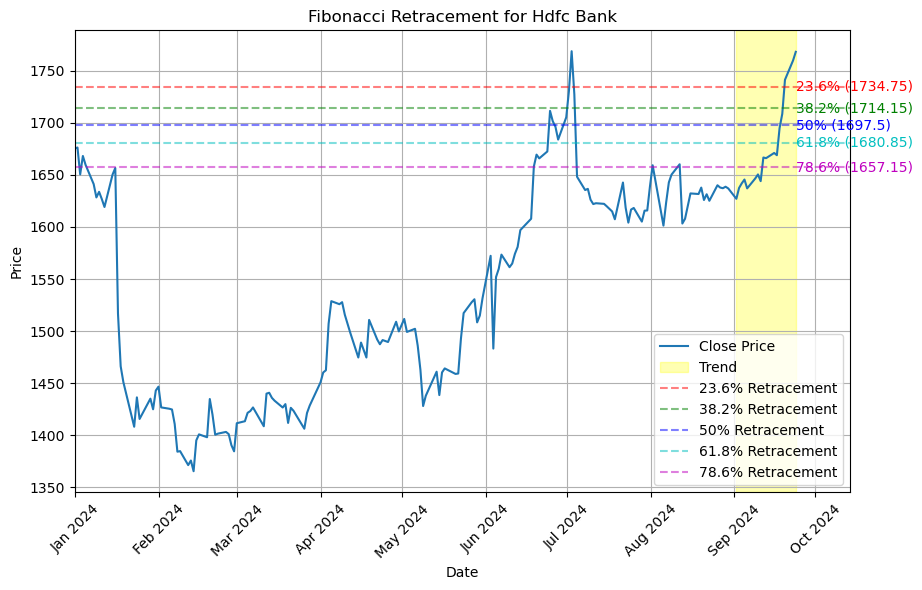

Trend: uptrend
Fibonacci Levels for Hdfc Bank:
0% level: 1768.05
23.6% level: 1734.75
38.2% level: 1714.15
50.0% level: 1697.5
61.8% level: 1680.85
78.6% level: 1657.15
100% level: 1626.95


In [71]:
visualise_fib2(d)

In [13]:
def visualise_macd(data):
    fig, ax1 = plt.subplots(1, figsize=(12,8))
    ax1.plot(data.index, data['MACD'], label='MACD', color='blue', linewidth=1.5)
    ax1.plot(data.index, data['Signal Line'], label='Signal Line', color='red', linestyle='--', linewidth=1.5)
    ax1.bar(data.index, data['MACD'] - data['Signal Line'], color='gray', alpha=0.5, label='MACD Histogram')
    ax1.legend(loc='upper left')
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.set_title("MACD")

In [14]:
def visualise_rsi(data):
    
    fig, ax2 = plt.subplots(1, figsize=(12,8))
    ax2.plot(data.index, data['RSI'], label='RSI', color='green', linewidth=1.5)
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought threshold
    ax2.axhline(30, linestyle='--', alpha=0.5, color='blue')  # Oversold threshold
    ax2.legend(loc='upper left')
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.set_title("RSI")

Enter a name: tata steel

Sell your stocks of Tata Steel

 The pe ratio is 1912222534901.76 which is above 20, hence SELL

 The macd line and the signal are above 0, hence HOLD/SELL

 RSI value is 52.678, this value suggests that the stock is being brought and can become over-brought, hence SELL

Market Cap of Tata Steel: 1912222534901.76


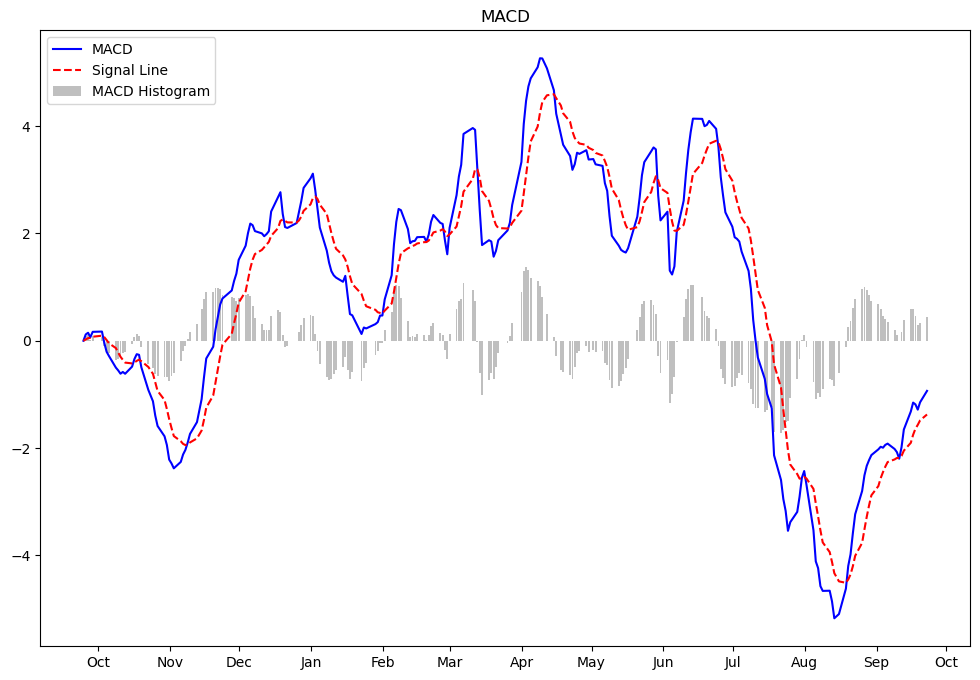

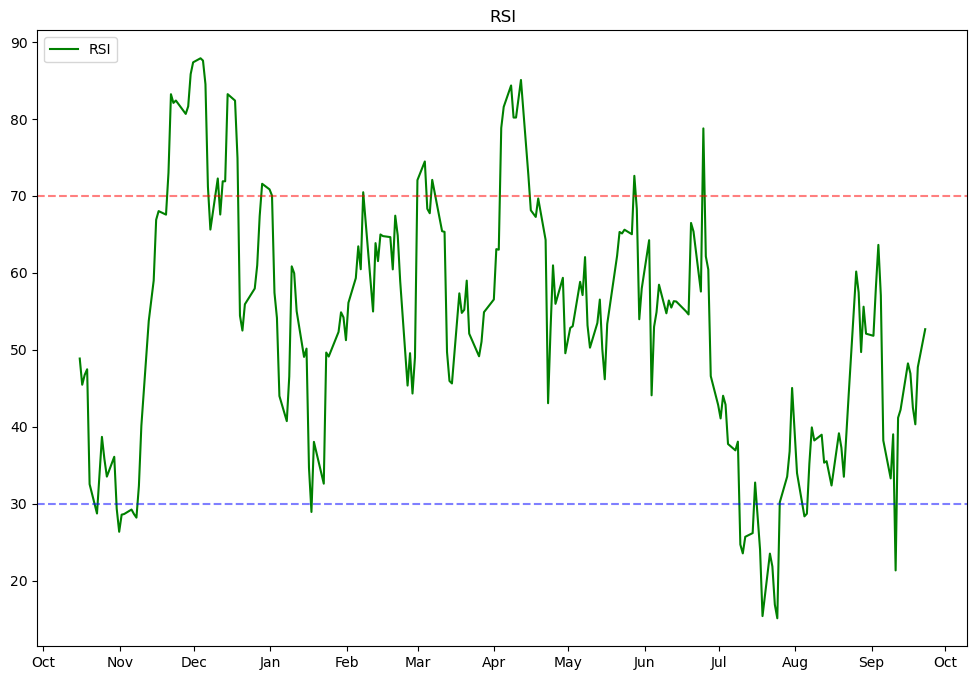

In [27]:
#INPUT
name = input('Enter a name: ')

# PREPROCESSING THE NAME
symbol = search_stock_symbol(name)
symbol = symbol_changes(symbol)

# API CALL
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')


info = pe_and_market_cap(symbol)
response = []

if info[2] != 1:
    
    print('The company is not large cap')
    
else:
    pe = info[0]
    
    if pe <= 20:
        response.append(1)
        pe_response = f'The pe ratio is {round(pe,2)} which is below 20, hence BUY'
        
    else:
        response.append(0)
        pe_response = f'The pe ratio is {round(pe,2)} which is above 20, hence SELL'
        
        
    r = rsi(name)
    rsi_value = r['RSI']
    
    
    if 70 > rsi_value.iloc[-1] > 50:
        response.append(0)
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, this value suggests that the stock is being brought and can become over-brought, hence SELL'
        
    elif 50 < rsi_value.iloc[-1] < 30 :
        response.append(1)
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, this value suggests that the stock is being sold and can become oversold, hence BUY'
        
    elif rsi_value.iloc[-1] > 70:
        response.append(0)
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, this value suggests that the stock is overbrought, hence SELL'
        
        
    elif rsi_value.iloc[-1] < 30:
        response.append(1)
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, this value suggests that the stock is oversold, hence BUY'
    
    ma = macd(name)
    result = ma[-1:]
    
    pred = ma['Prediction']
    
    if pred.iloc[-1] == 'Buy':
        response.append(1)
        macd_repsonse = f'The macd line is cutting from above, hence BUY'
        
    elif pred.iloc[-1] == 'Sell':
        response.append(0)
        macd_response = f'The macd line us cutting from below, hence SELL'
        
    else:
        
        val = ma['Histogram']
        
        if val.iloc[-1] < 0:
            response.append(0)
            macd_response = f"The macd line and the signal are below 0, hence HOLD/BUY"
            
        else:
            response.append(1)
            macd_response = f"The macd line and the signal are above 0, hence HOLD/SELL"
            

s = sum(response)

if s >= 2:
    print(f'\nBuy stocks of {name.title()}')
    
else:
    print(f'\nSell your stocks of {name.title()}')
    
print('\n',pe_response)
    
visualise_macd(ma)
print('\n', macd_response)
visualise_rsi(r)
print('\n', rsi_response)
print(f'\nMarket Cap of {name.title()}: {info[0]}')